In [1]:
from ase.io import read,Trajectory
from ase.neighborlist import natural_cutoffs, NeighborList
import torch
import numpy as np
from pathlib import Path

In [2]:
traj = Trajectory('simulation_300K.traj')
atoms = traj[0]
NL = NeighborList(natural_cutoffs(atoms), self_interaction=False)
NL.update(atoms)
bonds = NL.get_connectivity_matrix().todense().nonzero()
bonds = torch.tensor(bonds)
bonds.shape

/tmp/ipykernel_1272039/3545807433.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  bonds = torch.tensor(bonds)


torch.Size([2, 166])

In [3]:
print(atoms)

Atoms(symbols='H4Ca10O36Si12', pbc=True, cell=[[11.2714, 0.0, 0.0], [-0.043430255, 7.399172541, 0.0], [-0.324002368, -1.991989071, 9.511957932000001]], momenta=..., calculator=SinglePointCalculator(...))


In [4]:
def get_thermo(filename):
    """
    read thermo logs.
    """
    with open(filename, 'r') as f:
        thermo = f.read().splitlines()
        sim_time, Et, Ep, Ek, T = [], [], [], [], []
        for i in range(1, len(thermo)):
            try:
                t, Etot, Epot, Ekin, Temp = [float(x) for x in thermo[i].split(' ') if x]
                sim_time.append(t)
                Et.append(Etot)
                Ep.append(Epot)
                Ek.append(Ekin)
                T.append(Temp)
            except:
                sim_time, Et, Ep, Ek, T = [], [], [], [], []
    thermo = {
        'time': sim_time,
        'Et': Et,
        'Ep': Ep,
        'Ek': Ek,
        'T': T
    }
    return thermo

def mae(x, y, factor):
    return np.abs(x-y).mean() * factor

def distance_pbc(x0, x1, lattices):
    delta = torch.abs(x0 - x1)
    lattices = lattices.view(-1,1,3)
    delta = torch.where(delta > 0.5 * lattices, delta - lattices, delta)
    return torch.sqrt((delta ** 2).sum(dim=-1))

In [5]:
def load_run(md_dir, xlim, bins, stability_threshold, gt_traj, hist_gt):
    """
    md_dir: directory to the finished MD simulation.
    """
    if not isinstance(md_dir, Path):
        md_dir = Path(md_dir)
    Dev_mean = []
    Dev_max = []
    Dev_min = []
    #model_name = md_dir.parts[-2]
    #seed = md_dir.parts[-1][-1]
    run = {'name': 'tob',}
    
    # get bonds
    traj = Trajectory(md_dir / 'simulation_300K.traj')
    atoms = traj[0]
    NL = NeighborList(natural_cutoffs(atoms), self_interaction=False)
    NL.update(atoms)
    bonds = NL.get_connectivity_matrix().todense().nonzero()
    bonds = torch.tensor(bonds)
    
    # process trajectory
    traj = [x.positions for x in traj]
    run['traj'] = torch.from_numpy(np.stack(traj))
    run['traj'] = torch.unique(run['traj'], dim=0) # remove repeated frames from restarting.

    # load thermo log
    run['thermo'] = get_thermo(md_dir / 'simulation_300K.log')
    T = np.array(run['thermo']['T']) 
    collapse_pt = len(T)
    md_time = np.array(run['thermo']['time'])
    
    # track stability
    bond_lens = distance_pbc(
        gt_traj[:, bonds[0]], gt_traj[:, bonds[1]], torch.FloatTensor([11.27,7.40,9.72])) #[11.27, 7.40, 9.51]
    mean_bond_lens = bond_lens.mean(dim=0)
    
    for i in range(1, len(T)):
        bond_lens = distance_pbc(
            run['traj'][(i-1):i, bonds[0]], run['traj'][(i-1):i, bonds[1]], torch.FloatTensor([11.27,7.40,9.72]))
        zero_bond_lens = distance_pbc(
            run['traj'][0:1, bonds[0]], run['traj'][0:1, bonds[1]], torch.FloatTensor([11.27,7.40,9.72]))
        max_dev = (bond_lens[0] - zero_bond_lens).abs().max()
        mean_dev = (bond_lens[0] - zero_bond_lens).abs().mean()
        min_dev = (bond_lens[0] - zero_bond_lens).abs().min()
        Dev_mean.append(mean_dev)
        Dev_max.append(max_dev)
        Dev_min.append(min_dev)
        if  mean_dev > stability_threshold:
            collapse_pt = i
            break
    run['collapse_pt'] = collapse_pt
    
    # compute h(r)
    hist_pred = get_hr(run['traj'][0:collapse_pt], bins)
    #hist_gt = get_hr(run['traj'][0:1], bins)
    hr_mae = mae(hist_pred, hist_gt, xlim)
    run['hr'] = hist_pred
    run['hr_error'] = hr_mae
    run['Dev_mean'] = Dev_mean
    run['Dev_max'] = Dev_max
    run['Dev_min'] = Dev_min
    
    # load test metrics
    if (md_dir / 'test_metric.json').exists():
        test_metrics = get_test_metrics(md_dir)
        run.update(test_metrics)
    
    return run

In [6]:
def get_hr(traj, bins):
    """
    compute h(r) for MD17 simulations.
    traj: T x N_atoms x 3
    """
    pdist = torch.cdist(traj, traj).flatten()
    hist, _ = np.histogram(pdist[:].flatten().numpy(), bins, density=True)
    return hist

In [7]:
stability_threshold = 0.15
xlim = 10
n_bins = 500
bins = np.linspace(1e-6, xlim, n_bins + 1) # for computing h(r)

gt_data = np.load('tob9.npz')
gt_traj = torch.FloatTensor(gt_data.f.R)
hist_gt= get_hr(gt_traj, bins)
md_dir = './'

run = load_run(md_dir, xlim, bins, stability_threshold, gt_traj, hist_gt)

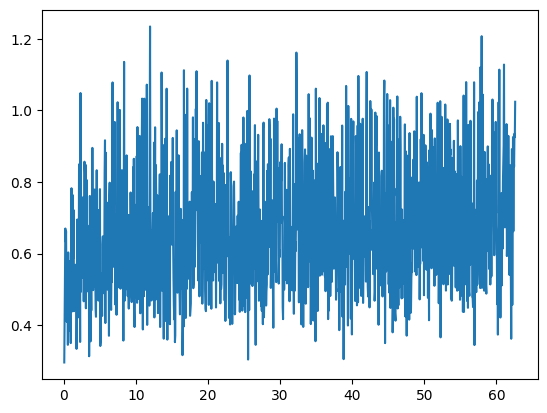

In [8]:
import matplotlib.pyplot as plt

x = np.arange(len(run['Dev_mean'])) / 20
y1 = run['Dev_mean']
y2 = run['Dev_max']
y3 = run['Dev_min']
plt.plot(x[1:10000],y2[1:10000])
#run['Dev_mean']

In [9]:
collapse_ps = (run['collapse_pt']-1) / 20
hr_mae = run['hr_error']

print(f'stability: {collapse_ps:.1f} ps \nh(r) mae: {hr_mae:.3f}')

stability: 62.6 ps 
h(r) mae: 0.061
